# Libraries, Reproducibility and Graphic Parameters

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima


from keras.utils import plot_model


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# reproducibility
from tensorflow.random import set_seed
set_seed(89)
from numpy.random import seed
seed(7)
from random import seed as seed1


# importing modules:
from preprocessing import *
from RNN import *
from ARIMA import *

# graphic parameters
sns.set(rc={'figure.figsize':(18,9.27)})
sns.set_style("whitegrid")
#pd.options.display.float_format='{:.2f}'.format

# Loading, Cleaning of data and simple Feature Engineering

### Loading

In [2]:
ftsemib=pd.read_csv('Data\FTSEMIB.csv')
dax=pd.read_csv('Data/DAX.csv')
sp=pd.read_csv('Data/S&P.csv')

print('Number of observations: \nFTSEMIB: {}\nS&P: {}\nDAX: {}\n'.format(ftsemib.shape[0],sp.shape[0],dax.shape[0]))
print('First observation:\nFTSEMIB: {} \nS&P: {}\nDAX: {}'.format(ftsemib.DATA[0],sp.DATA[0],dax.DATA[0]))

Number of observations: 
FTSEMIB: 2537
S&P: 2516
DAX: 2529

First observation:
FTSEMIB: 03/11/11 
S&P: 03/11/11
DAX: 03/11/11


### Indexing and joining

In [3]:
# converting to datetime
ftsemib['DATA']=pd.to_datetime(ftsemib['DATA'],format='%d/%m/%y')
dax['DATA']=pd.to_datetime(dax['DATA'],format='%d/%m/%y')
sp['DATA']=pd.to_datetime(sp['DATA'],format='%d/%m/%y')

In [4]:
# indexing all dataframes with data so that joining is easier
ftsemib.index=ftsemib.DATA
dax.index=dax.DATA
sp.index=sp.DATA

ftsemib.drop('DATA',axis=1,inplace=True)

# keeping only closure for DAX and openings for S&P
dax=dax.iloc[:,4]
sp=sp.iloc[:,1]

# DAX and S&P have some Nans, the following function uses the most recent value to replace them
for day in ftsemib.index:
  if day not in dax.index:
    dax[day]=previous(day,dax)

for day in ftsemib.index:
  if day not in sp.index:
    sp[day]=previous(day,sp)

# adding the two new columns
dati_completi=ftsemib.join(dax,rsuffix='_DAX')
dati_completi=dati_completi.join(sp,rsuffix='_SP')
dati_completi.head(4)


,APERTURA,MASSIMO,MINIMO,CHIUSURA,VAR % CLOSE,VOLUME,CHIUSURA_DAX,APERTURA_SP
DATA,,,,,,,,
2011-11-03,"14.904,32","15.983,70","14.884,74","15.766,16","0,00",1295687802,"6.133,20","1.238,25"
2011-11-04,"15.890,08","16.014,36","15.210,73","15.346,55","-2,66",1028623546,"5.966,15","1.260,82"
2011-11-07,"15.187,85","15.822,69","14.937,09","15.548,94","1,32",1073642958,"5.928,70","1.253,21"
2011-11-08,"15.600,96","16.023,41","15.564,02","15.664,06","0,74",897599022,"5.961,45","1.261,12"


### Casting to floats

In [5]:
dati_completi.dtypes

APERTURA        object
MASSIMO         object
MINIMO          object
CHIUSURA        object
VAR % CLOSE     object
VOLUME           int64
CHIUSURA_DAX    object
APERTURA_SP     object
dtype: object

In [6]:
for i in range(dati_completi.shape[1]):
  if i!=5: dati_completi.iloc[:,i]=dati_completi.iloc[:,i].apply(replace,x='.',y='').apply(replace,x=',',y='.').astype('float64')
dati_completi.dtypes

APERTURA        float64
MASSIMO         float64
MINIMO          float64
CHIUSURA        float64
VAR % CLOSE     float64
VOLUME            int64
CHIUSURA_DAX    float64
APERTURA_SP     float64
dtype: object

### Creation of Range feature and differentiated data

In [7]:
dati_completi['RANGE']=dati_completi['MASSIMO']-dati_completi['MINIMO']
dati_completi['DIFFERENZE PRIME']=dati_completi.CHIUSURA.diff()
dati_completi.head(4)

,APERTURA,MASSIMO,MINIMO,CHIUSURA,VAR % CLOSE,VOLUME,CHIUSURA_DAX,APERTURA_SP,RANGE,DIFFERENZE PRIME
DATA,,,,,,,,,,
2011-11-03,14904.32,15983.70,14884.74,15766.16,0.00,1295687802,6133.20,1238.25,1098.96,NaN
2011-11-04,15890.08,16014.36,15210.73,15346.55,-2.66,1028623546,5966.15,1260.82,803.63,-419.61
2011-11-07,15187.85,15822.69,14937.09,15548.94,1.32,1073642958,5928.70,1253.21,885.60,202.39
2011-11-08,15600.96,16023.41,15564.02,15664.06,0.74,897599022,5961.45,1261.12,459.39,115.12


# Visualization

In [8]:
print('Most important descriptive statistics:')
dati_completi.describe()

Most important descriptive statistics:


,APERTURA,MASSIMO,MINIMO,CHIUSURA,VAR % CLOSE,VOLUME,CHIUSURA_DAX,APERTURA_SP,RANGE,DIFFERENZE PRIME
count,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2.537000e+03,2537.000000,2537.000000,2537.000000,2536.000000
mean,19976.248703,20130.168143,19804.288912,19968.741892,0.033197,6.334601e+08,10868.828616,2417.199669,325.879231,4.578750
std,3036.059081,3019.601165,3051.415794,3039.446741,1.500067,2.909760e+08,2385.582289,793.160668,181.364964,282.640074
min,12357.700000,12656.380000,12295.760000,12362.510000,-16.920000,1.483866e+08,5428.100000,1158.670000,85.090000,-3034.200000
25%,17413.490000,17587.350000,17237.100000,17431.170000,-0.690000,4.119858e+08,9377.200000,1875.270000,212.670000,-137.175000
50%,20299.100000,20463.340000,20157.420000,20324.230000,0.070000,5.704865e+08,11130.200000,2182.240000,286.320000,14.635000
75%,22194.410000,22324.770000,21999.890000,22169.420000,0.820000,7.992666e+08,12543.900000,2861.510000,389.210000,165.992500
max,27172.870000,27377.870000,27140.650000,27377.870000,8.930000,2.676921e+09,15977.450000,4627.300000,2765.420000,1388.800000


Text(0.5, 1.0, 'Valore del FTSEMIB in chiusura')

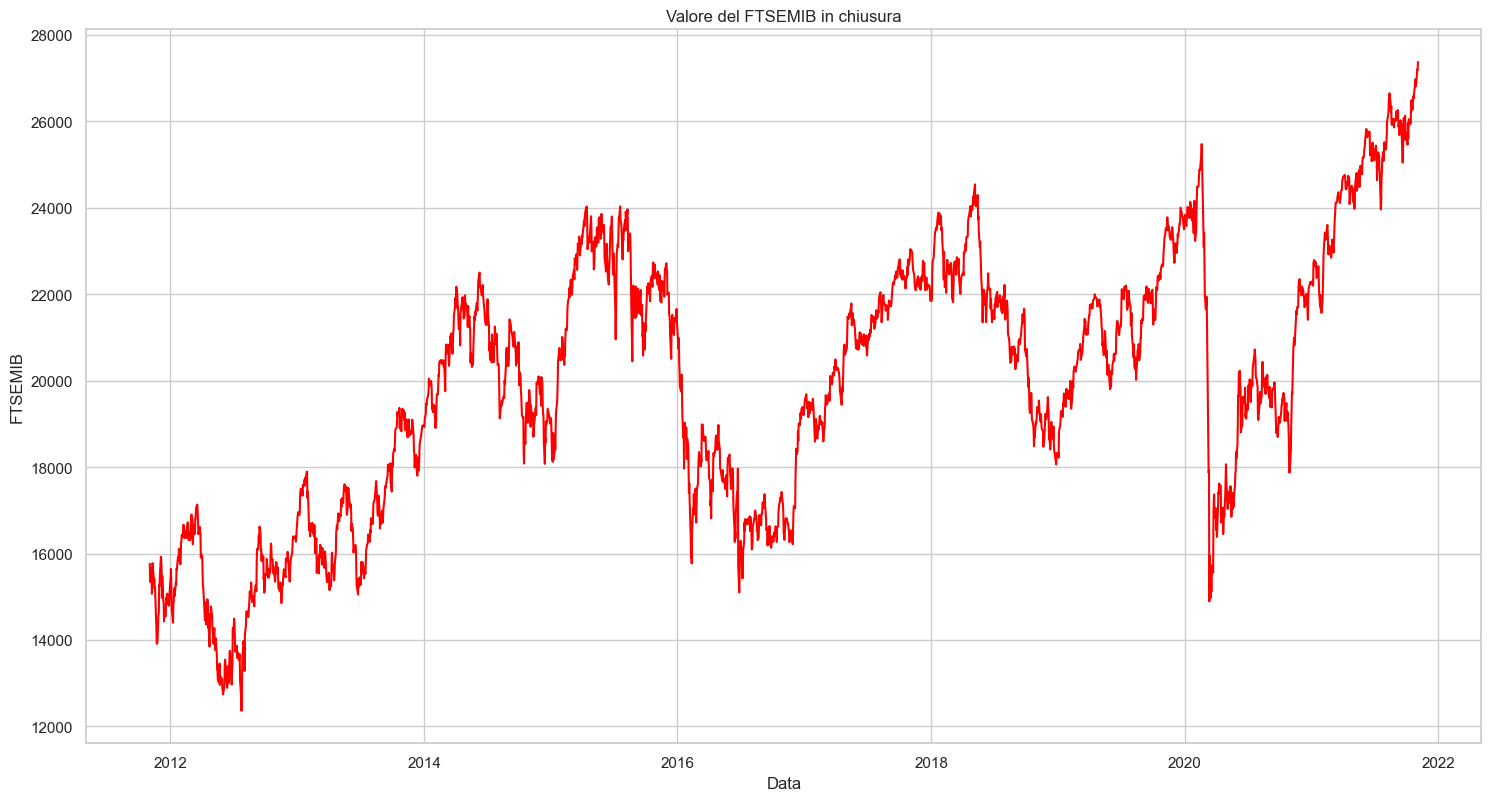

In [9]:
y=dati_completi.CHIUSURA
x=dati_completi.index
p=sns.lineplot(x=x,y=y,color='red')
p.set_xlabel('Data')
p.set_ylabel('FTSEMIB')
p.set_title('Valore del FTSEMIB in chiusura')

Text(0.5, 1.0, 'Differentiated Time series')

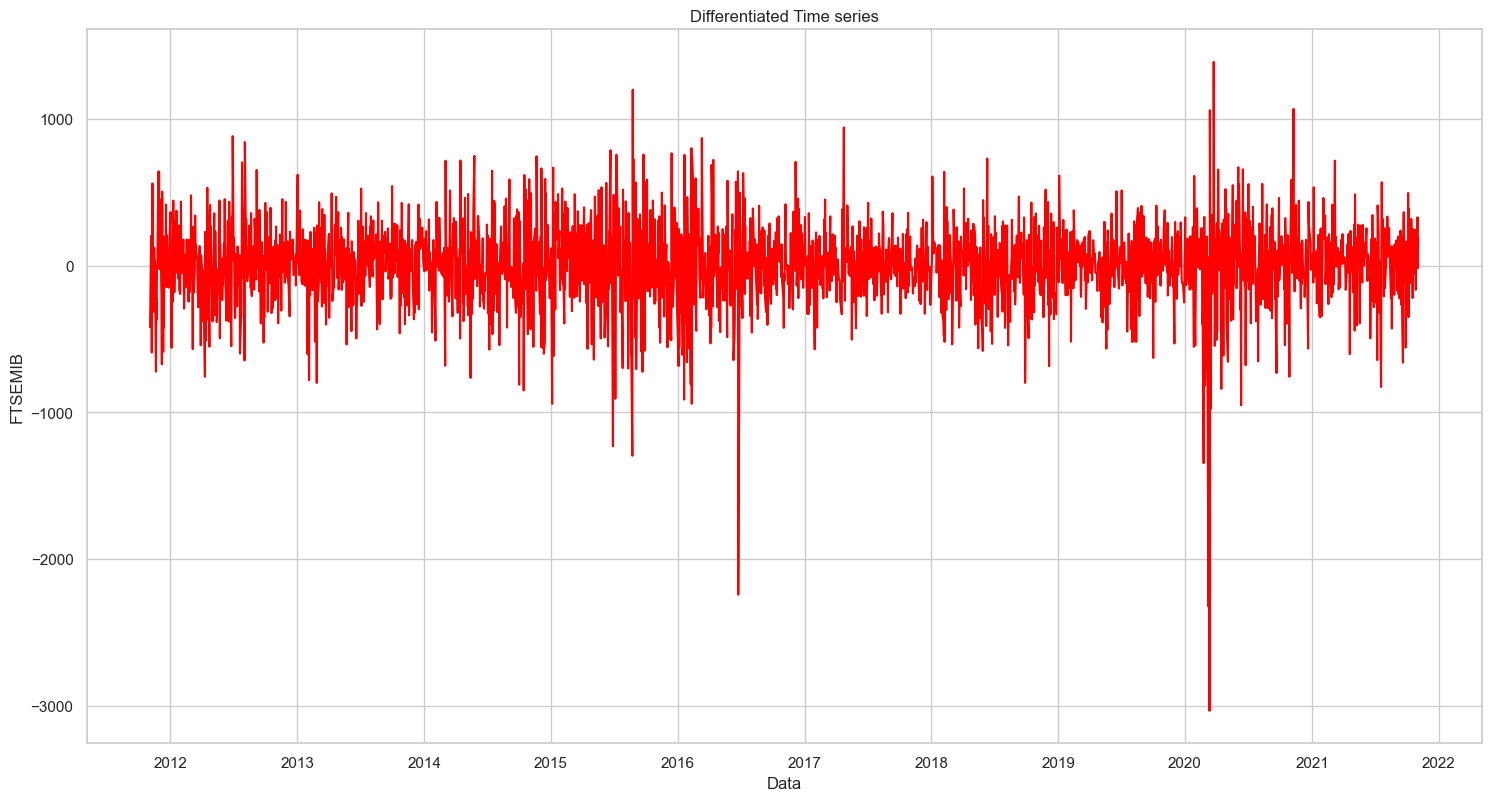

In [10]:
y=dati_completi.iloc[:,9]
x=dati_completi.index
p=sns.lineplot(x=x,y=y,color='red')
p.set_xlabel('Data')
p.set_ylabel('FTSEMIB')
p.set_title('Differentiated Time series')

# RNN

In [11]:
n_timestamps=20 # length of the input for the RNN

## Horizon 10:

In [12]:
n_outputs=10

### RNN with non differentiated and not external data

Start Training
Training Completed
MAE on test set: 1006.9983675789077


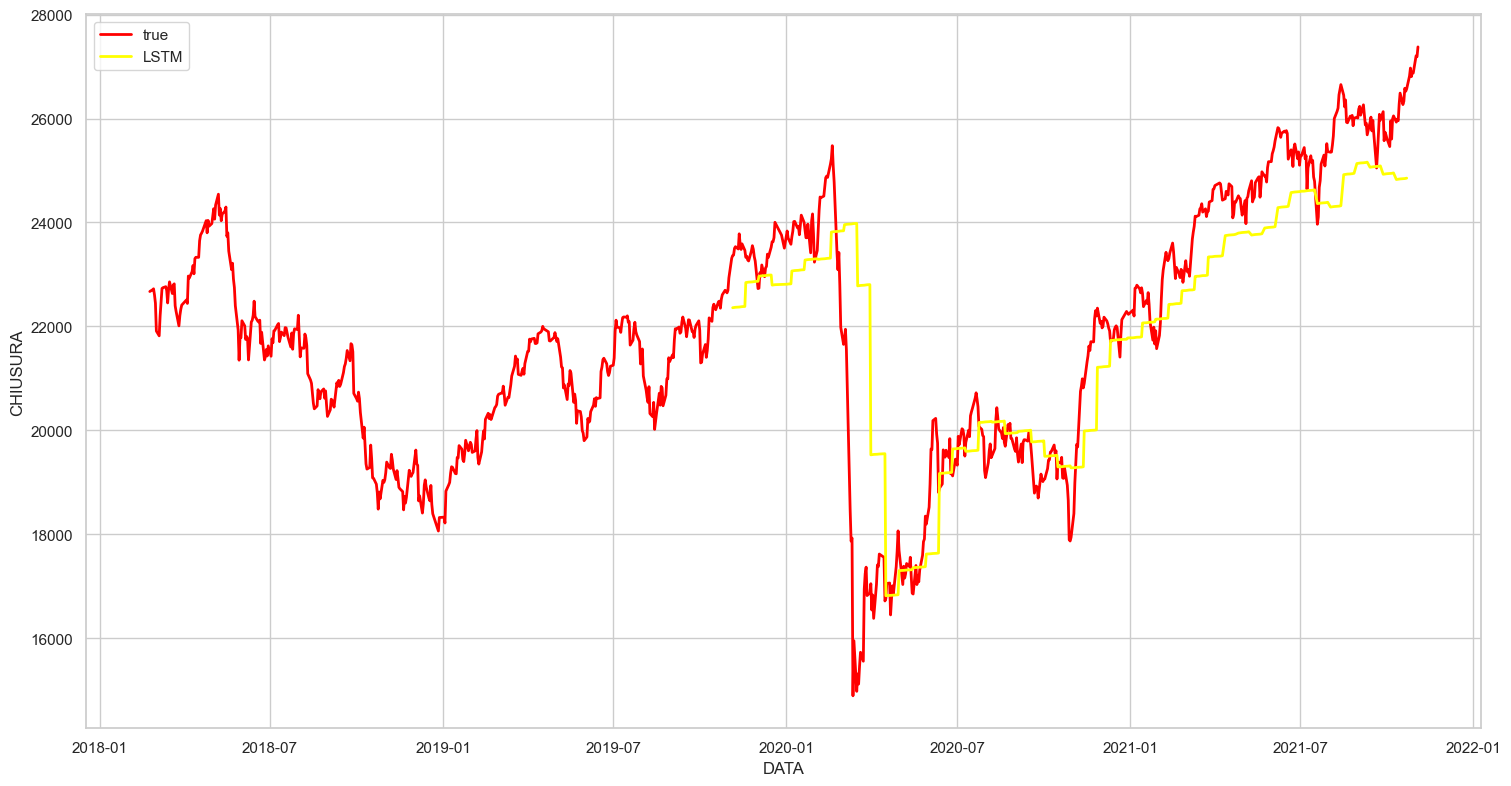

In [13]:
N=dati_completi.shape[0]
N_train=int(0.8*N) # number of obs reserved for training
dati_y=dati_completi.iloc[:,3] 
dati_X=dati_completi.iloc[:,[3]]

mae_rnn1=train_evaluation_loop(dati_X,dati_y,dati_completi,n_timestamps,n_outputs, N_train, epochs=90)

### RNN with differentiated and not external data

In [14]:
dati_completi=dati_completi.drop(dati_completi.index[0],axis=0) # needed since first observation is lost with differentiation

Start Training
Training Completed
MAE on test set: 443.4329273001823


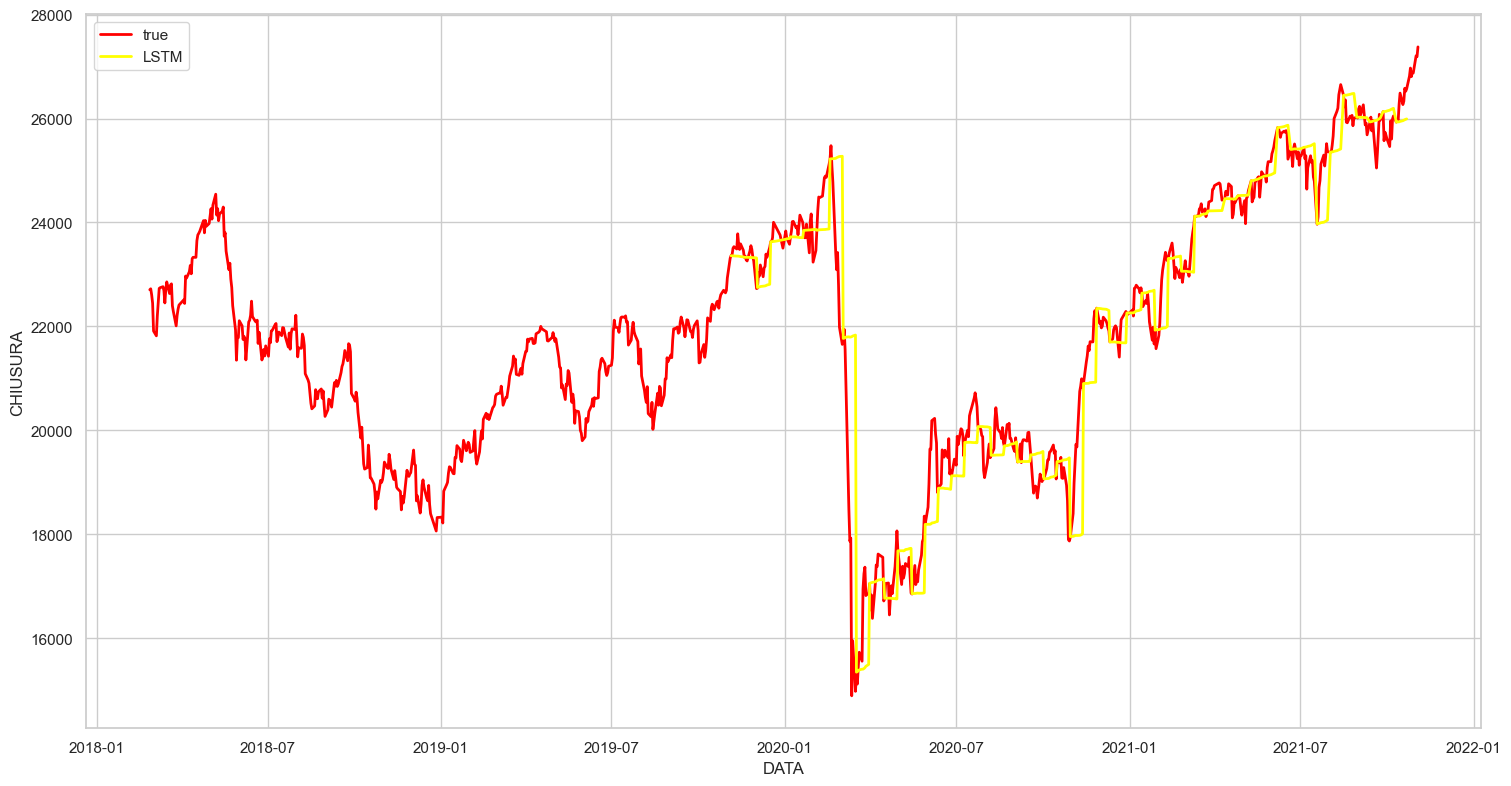

In [15]:
N=dati_completi.shape[0]
N_train=int(0.8*N) # number of obs reserved for training

dati_y=dati_completi.iloc[:,9] 
dati_X=dati_completi.iloc[:,[9]]
not_diff_data=dati_completi.iloc[:,3] 

mae_rnn2=train_evaluation_loop(dati_X,dati_y,dati_completi,n_timestamps,n_outputs, N_train, not_diff_data)

### RNN with differentiated and external data

Start Training
Training Completed
MAE on test set: 440.5308598972724


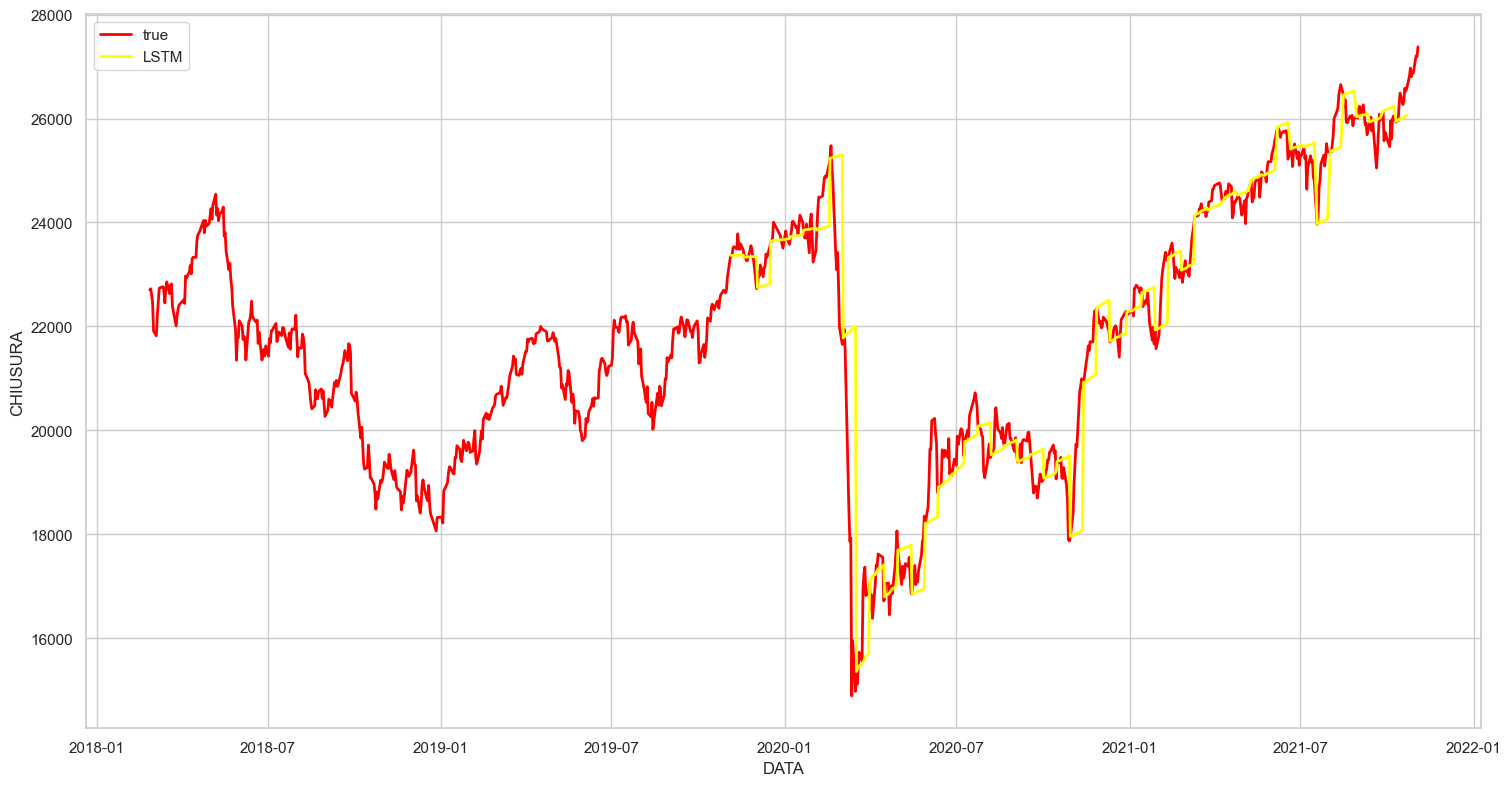

In [16]:
dati_y=dati_completi.iloc[:,9] #variabile target (la chiusura del FTSEMIB)
dati_X=dati_completi.iloc[:,[5,6,7,8,9]]


mae_rnn3, prev_rnn=train_evaluation_loop(dati_X,dati_y,dati_completi,n_timestamps,n_outputs, N_train, not_diff_data, ret_prev=True)

## ARIMA

Start Identification
Identification completed
Start test
Test completed
MAE on test set: 578.2800719672448


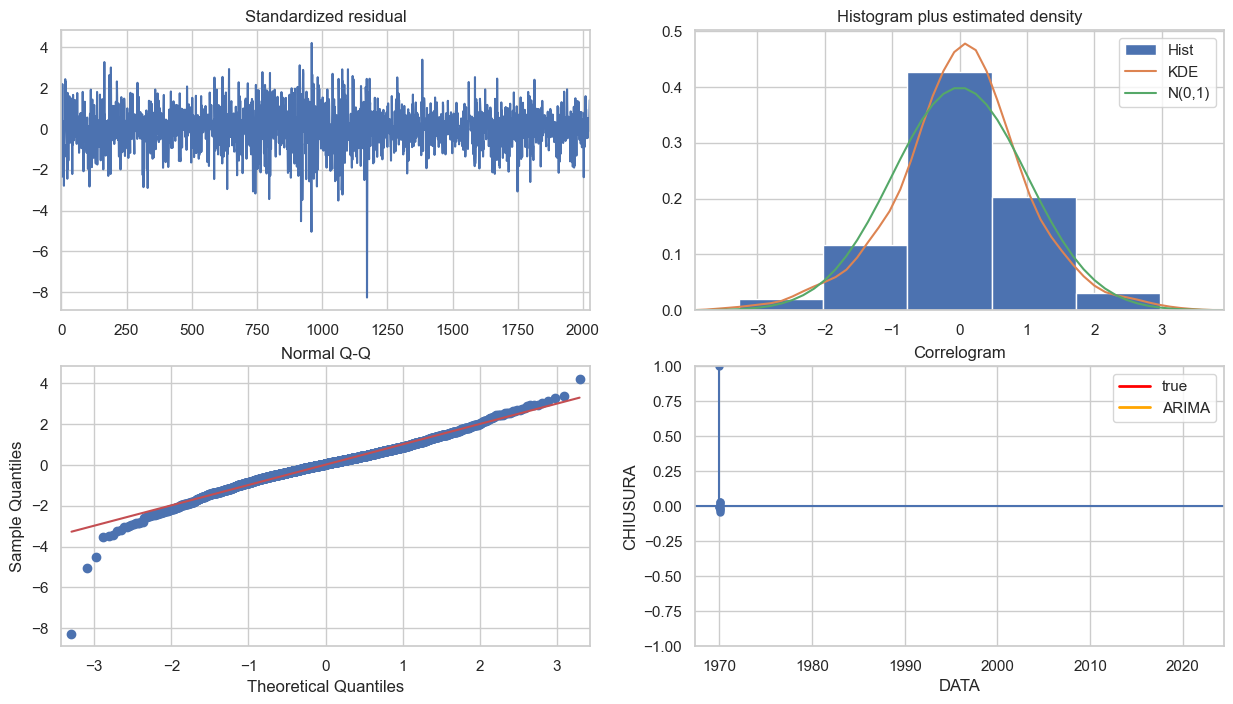

In [17]:

chiusure_pd=dati_completi.iloc[:,[3]]
chiusure=np.array(chiusure_pd)

mae_arima1, prev_arima=train_evaluation_loop_arima(chiusure,chiusure_pd,dati_completi,N_train, n_outputs, ret_prev=True)


## Comparison: Visualization

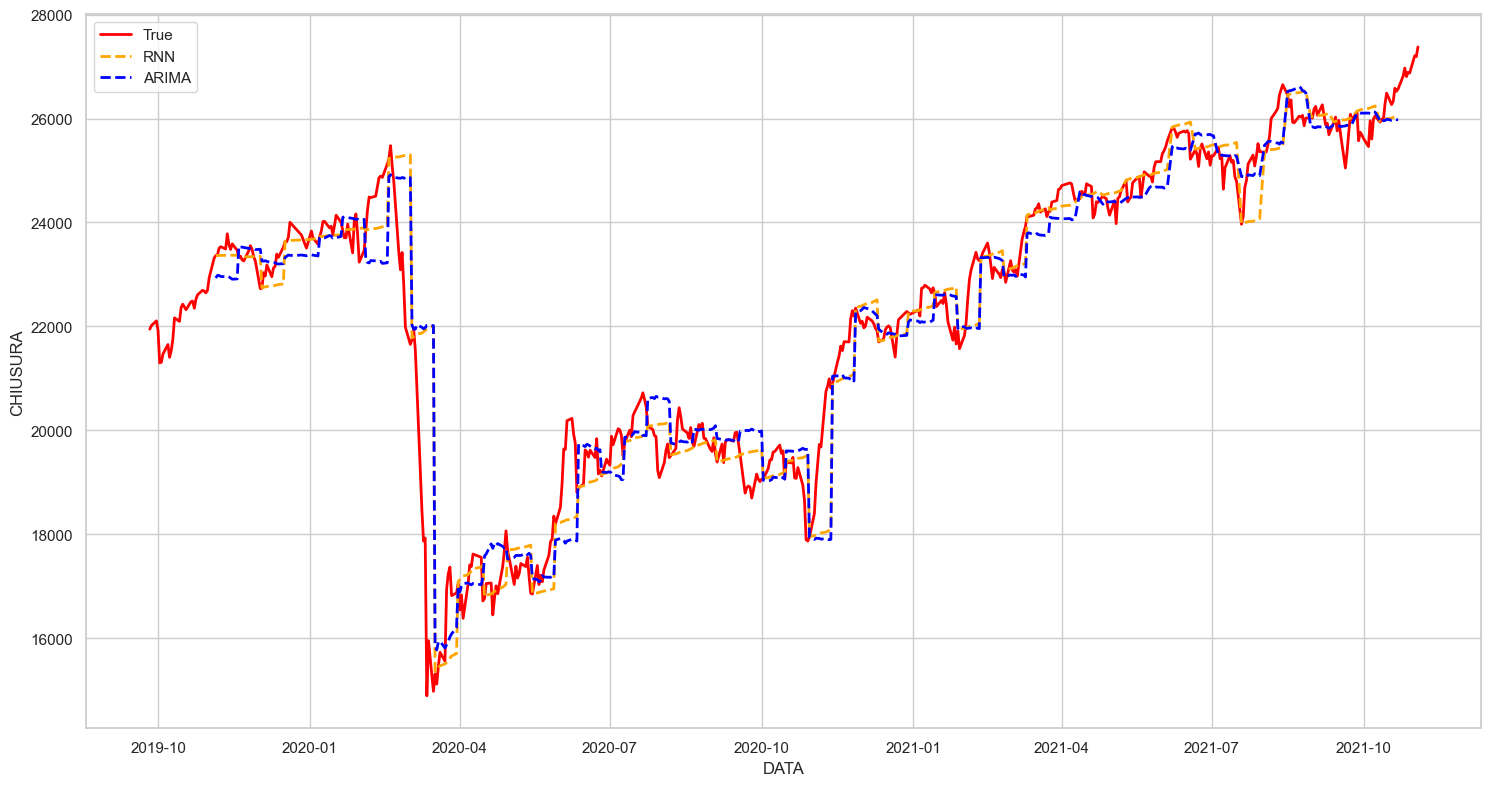

In [18]:
y=dati_completi.CHIUSURA
x=dati_completi.index

# only for last Neural Network and ARIMA
x_prev=dati_completi.index[N_train:-(dati_completi.shape[0]-N_train-len(prev_rnn))]
p=sns.lineplot(x=x[2000:],y=y[2000:],color='red',lw=2,label='True')
p=sns.lineplot(x=x_prev,y=prev_rnn,color='orange',lw=2,label='RNN',linestyle='--')
p=sns.lineplot(x=x_prev,y=prev_arima,color='blue',lw=2,label='ARIMA',linestyle='--')
plt.savefig('Images/Comparison.png')

# Horizon 1

In [19]:
n_outputs=1

### RNN

In [20]:
dati_y=dati_completi.iloc[:,9]
dati_X=dati_completi.iloc[:,[5,6,7,8,9]]


mae_rnn4=train_evaluation_loop(dati_X,dati_y,dati_completi,n_timestamps,n_outputs, N_train, not_diff_data, plot=False)

Start Training
Training Completed
MAE on test set: 12.177561392560309


### ARIMA



Start Identification
Identification completed
Start test
Test completed
MAE on test set: 309.90237369265657


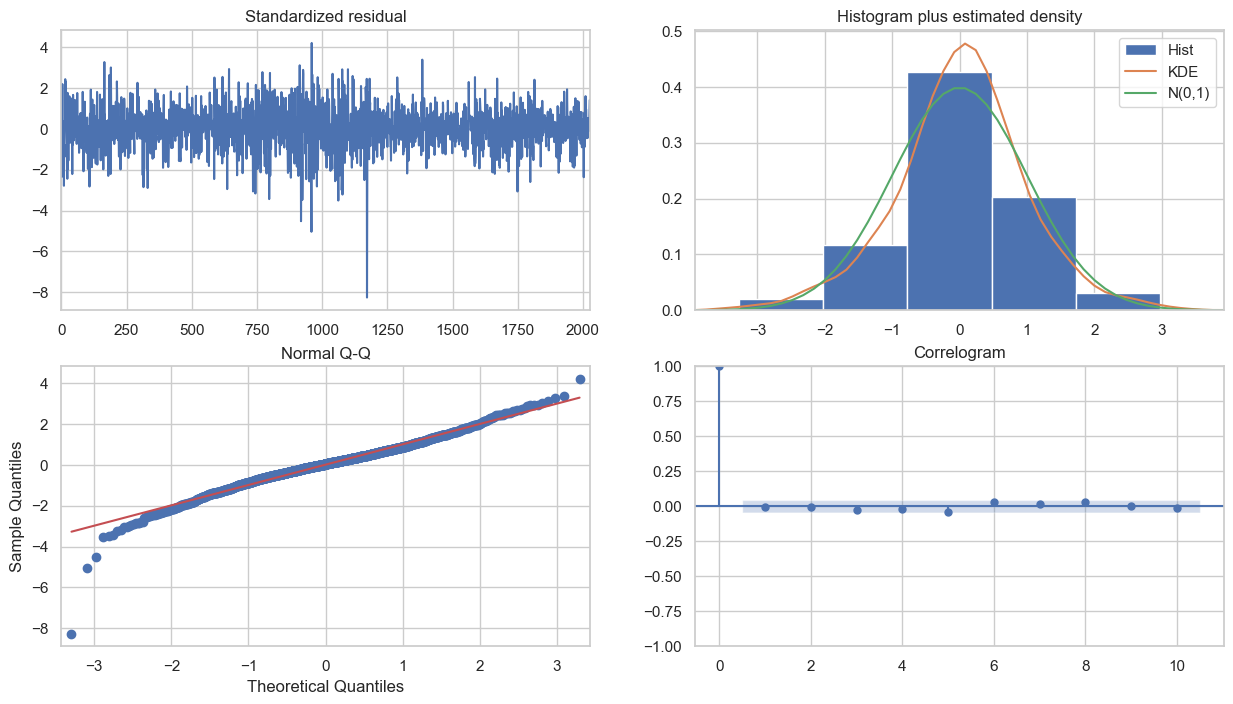

In [21]:
chiusure_pd=dati_completi.iloc[:,[3]]
chiusure=np.array(chiusure_pd)

mae_arima2=train_evaluation_loop_arima(chiusure,chiusure_pd,dati_completi,N_train, n_outputs, plot=False)

# Results

In [24]:
print('RNN prediction errors:')
print('Not diff and not ext data: {}'.format(mae_rnn1))
print('Diff and not ext data: {}'.format(mae_rnn2))
print('Diff and ext data: {}'.format(mae_rnn3))
print('Diff and ext data horizon 1: {}'.format(mae_rnn4))

print('\nARIMA prediction errors:')
print('Horizon 10: {}'.format(mae_arima1))
print('Horizon 1: {}'.format(mae_arima2))

RNN prediction errors:
Not diff and not ext data: 1006.9983675789077
Diff and not ext data: 443.4329273001823
Diff and ext data: 440.5308598972724
Diff and ext data horizon 1: 12.177561392560309

ARIMA prediction errors:
Horizon 10: 578.2800719672448
Horizon 1: 309.90237369265657
